In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from Game import *

Version:  0.2.23


In [3]:
from RobotSim373 import *

Version:  0.0.17


In [4]:
def initial_state(N=20):
    return N

def show_state(state):
    print("There are ",state,"sticks.")
    
def valid_moves(state,player):
    if state==1:
        return [1]
    elif state==2:
        return [1,2]
    else:
        return [1,2,3]
    
def update_state(state,player,move):
    # move = number of sticks to pick up
    new_state=state-move # remove the sticks
    return new_state

def win_status(state,player):
    if state==0:
        return 'lose'
    elif state==1:
        return 'win'
    else:
        return None
 

In [5]:
def human_move(state,player):
    print("Player ",player)
    move=int(input("How many sticks?"))
    return move

In [6]:
def random_move(state,player):
    possible_moves=valid_moves(state,player)
    move=random.choice(possible_moves)
    return move


In [7]:
def robot_skittles_move(state,player,S):
    if not state in S:
        move=random_move(state,player)
    else:
        move=weighted_choice(S[state])  
        
        
    return move



S=LoadTable('nim skittles table.json')



In [8]:
def build(robot):    
    
    up=Box(robot,2,2.5,width=1,height=.3,name='up')
    down=Box(robot,2,1.5,width=1,height=.3,name='down')
    center=Disk(robot,2,2,radius=0.3,name='center')
    left=Box(robot,1.3,2,width=1,height=.3,angle=90,name='left')
    right=Box(robot,2.7,2,width=1,height=.3,angle=-90,name='right')
    ram=Box(robot,3.2,2,width=.5,height=.5,name='ram',density=0)
    
    
    
    
    connect(up,down,'weld') 
    connect(center,down,'weld') 
    connect(up,center,'weld') 
    connect(center,left,'weld') 
    connect(left,right,'weld') 
    connect(right,ram,'weld') 

In [9]:
def act(t,robot):
    pass

## Just drawing it to make sure it looks ok

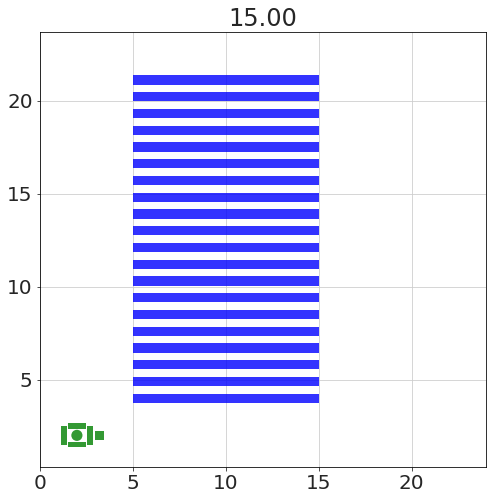

In [10]:
env=Environment(linearDamping=20) 
robot=Robot(env)
build(robot)

N=initial_state()

for i in range(N):
    Box(env,x=10,y=4+0.9*i,width=10,height=0.5)

run_sim(env,act,
        total_time=15,  # seconds
        dt=1/60,
        dt_display=15,  # make this larger for a faster display
        figure_width=8,
        plot_orientation=False,
       )    

## Behaviors

In [11]:
def stop(t,robot):
    robot['up'].F=0
    robot['ram'].F=0
    return True

def move_up(t,robot):
    robot['up'].F=20
    robot['up'].F_angle=90
    return False

def move_down(t,robot):
    robot['up'].F=-40
    robot['up'].F_angle=90
    return False


def count(t,robot):
    d=robot['up'].read_distance()
    
    robot.storage+=t,d
    
    if d<10:  # a stick
        if robot.already_counted:
            return False
        else:
            robot.count+=1
            robot.already_counted=True
            return False
    else:
        robot.already_counted=False
        return False
    
    
def until_close_to_wall(t,robot):
    d=robot['left'].read_distance()
    if d<1.5:
        return True
    else:
        return False
    
def until_close_to_floor(t,robot):
    d=robot['right'].read_distance()
    if d<1.5:
        return True
    else:
        return False
    
def until_stick(t,robot):
    d=robot['ram'].read_distance()
    if d<10:
        return True
    else:
        return False

def wait(dt):
    
    def _wait(t,robot):
        if t<dt:
            return False
        else:
            return True
        
    return _wait
    
def ramming_speed(t,robot):
    stop(t,robot)
    robot['ram'].F=100
    
    if robot['ram'].x>16:
        return True
    
    return False

def ramming_return(t,robot):
    stop(t,robot)
    robot['ram'].F=-100
    if robot['ram'].x<5:
        robot.taken_count+=1
        return True
    return False
      
    
def get_move(t,robot):
    S=LoadTable('nim skittles table.json')    
    state=robot.count
    player=robot.player
    
    if state not in S:
        move=random_move(state,player)
    else:
        move=top_choice(S[state])
        
    robot.move=move
    robot.taken_count=0
    return True
    
def check_done(t,robot):
    if robot.taken_count==robot.move:
        return True  # go to next state
    else:
        return 'up_to_one'

def check_win(t,robot):
    state=robot.count
    move=robot.move
    player=robot.player
    state=update_state(state,player,move)
    if win_status(state,player)=='win':
        return 'win dance'
    if win_status(state,player)=='lose':
        return 'lose dance'
    
    # otherwise just do the next robot state
    return True
        
def win_dance(t,robot):
    robot.color='c'
    robot['center'].F=100
    robot['center'].F_angle=0
    if t>15:
        return True

def lose_dance(t,robot):
    robot.color='r'
    robot['center'].F=100
    robot['center'].F_angle=t*5
    if t>15:
        return True
        
    
def monitor(t,robot):
    robot.message=robot.controller.current_state+" "+str(robot.count)
    if robot.move:
        robot.message+="(move %d taken %d)" % (robot.move,robot.taken_count)

In [12]:
take_sticks=StateMachine(
    {
     'up_to_one':([move_up,until_stick],'wait'),
     'wait':(wait(0.75),'ramming speed'),
     'ramming speed':(ramming_speed,'ramming return'),
     'ramming return':(ramming_return,'check if done'),
     'check if done':(check_done,'check if win'),
     'check if win':(check_win,'stop'),
     'win dance':(win_dance,'stop'),
     'lose dance':(lose_dance,'stop'),
     'stop':(stop,'_end_simulation'),   
    },
    first_state='up_to_one')


state_machine=StateMachine(
    {
     'count':([move_up,count,until_close_to_wall],'return'),
     'return':([move_down,until_close_to_floor],'get move'),
     'get move':(get_move,take_sticks),
    },
    first_state='count'
)
    




## Try a read state and a move

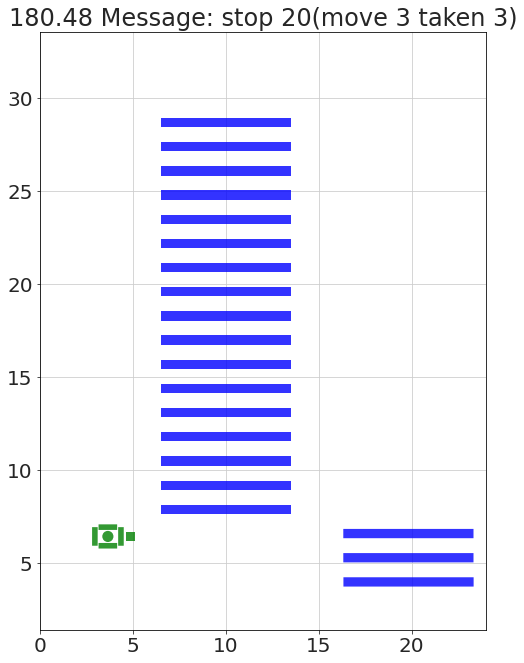

In [13]:
env=Environment(width=24,height=35,linearDamping=20) 
robot=Robot(env)
build(robot)

state=N=initial_state()

for i in range(N):
    Box(env,x=10,y=4+1.3*i,width=7,height=0.5)


robot.player=1
robot.taken_count=0
robot.count=0
robot.already_counted=False
robot.move=None

robot.controller=Controller(robot,state_machine)
robot.controller.monitor=monitor


run_sim(env,robot.controller,
        total_time=250,  # seconds
        dt=1/60,
        dt_display=1,  # make this larger for a faster display
        figure_width=8,
        plot_orientation=False,
       )    


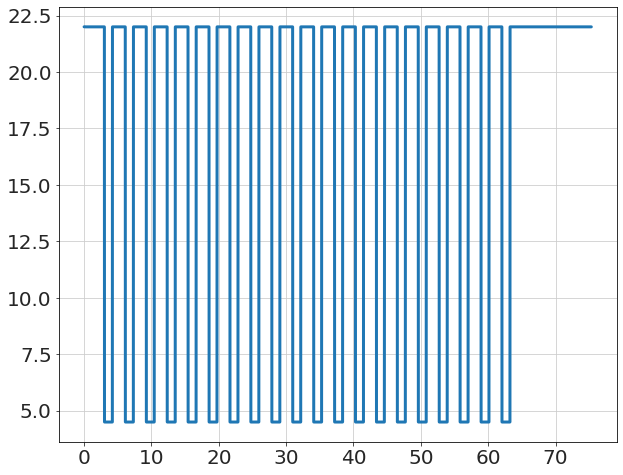

In [14]:
t,d=robot.storage.arrays()
plot(t,d)

## Try a human move

In [14]:
move=robot.move
player=2
state=update_state(state,player,move)

In [15]:
show_state(state)
move=human_move(state,player)

if not move in valid_moves(state,player):
    raise ValueError("Bad move!")

There are  17 sticks.
Player  2


How many sticks? 2


manually move the pieces

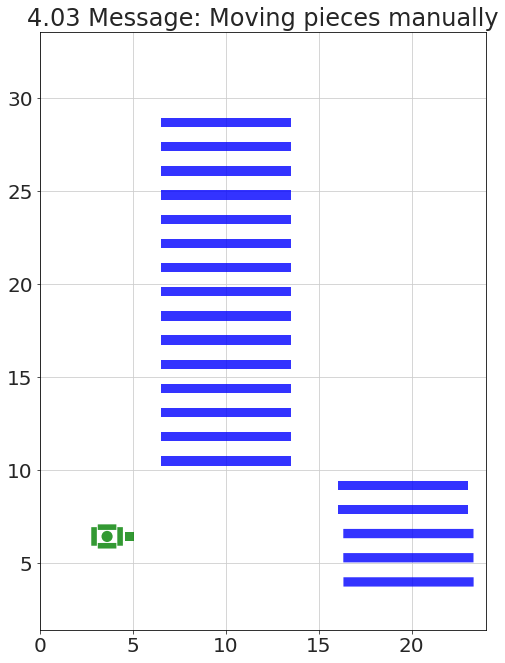

In [16]:
for i in range(move):
    stick=env.objects[N-state+i]
    stick.F=100
    
robot.message='Moving pieces manually'

run_sim(env,wait(4),
        total_time=6,  # seconds
        dt=1/60,
        dt_display=1,  # make this larger for a faster display
        figure_width=8,
        plot_orientation=False,
       )        

## Try another robot move

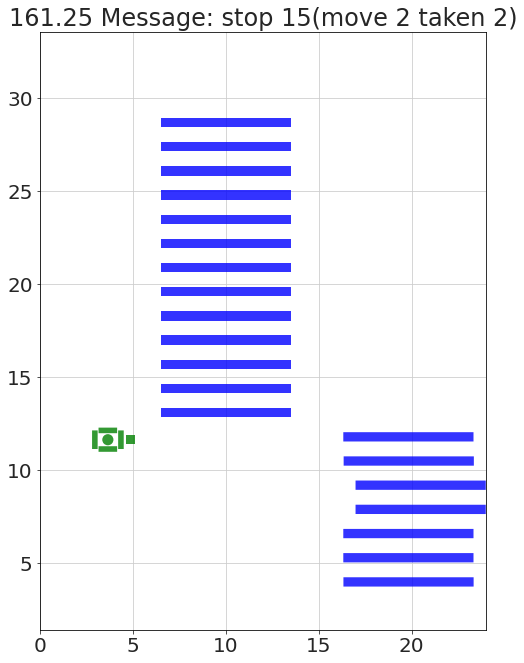

In [17]:
robot.count=0
robot.already_counted=False
robot.move=None

run_sim(env,robot.controller,
        total_time=200,  # seconds
        dt=1/60,
        dt_display=1,  # make this larger for a faster display
        figure_width=8,
        plot_orientation=False,
       )    

## Putting it in a loop

In [45]:
env=Environment(width=24,height=35,linearDamping=20) 
robot=Robot(env)
build(robot)

state=N=initial_state(2)

for i in range(N):
    Box(env,x=10,y=4+1.3*i,width=7,height=0.5)



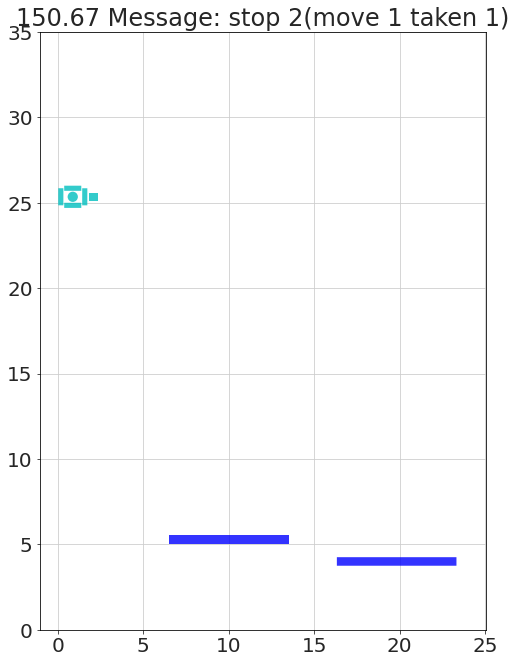

Player  1 wins.


In [46]:
while True:

    robot.player=1
    robot.taken_count=0
    robot.count=0
    robot.already_counted=False
    robot.move=None

    robot.controller=Controller(robot,state_machine)
    robot.controller.monitor=monitor


    run_sim(env,robot.controller,
            total_time=250,  # seconds
            dt=1/60,
            dt_display=1,  # make this larger for a faster display
            figure_width=8,
            plot_orientation=False,
           )
    
    
    move=robot.move
    player=robot.player
    state=update_state(state,player,move)    
    
    if win_status(state,player)=='win':
        print("Player ",player, "wins.")
        break
    elif win_status(state,player)=='lose':
        print("Player ",player, "loses.")
        break
        
    
    player=2
    show_state(state)
    move=human_move(state,player)

    if not move in valid_moves(state,player):
        raise ValueError("Bad move!")     

        
    for i in range(move):
        stick=env.objects[N-state+i]
        stick.F=100

    robot.message='Moving pieces manually'

    run_sim(env,wait(4),
            total_time=6,  # seconds
            dt=1/60,
            dt_display=1,  # make this larger for a faster display
            figure_width=8,
            plot_orientation=False,
           )    
    
    
    state=update_state(state,player,move)    
    
    if win_status(state,player)=='win':
        print("Player ",player, "wins.")
        break
    elif win_status(state,player)=='lose':
        print("Player ",player, "loses.")
        break
    